In [5]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple
from dataclasses import dataclass

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# ----------------------------
# Configuration
# ----------------------------
DATA_PATH = "data/housing_adequacy_dataset.csv"  # your saved dataset
SPLIT_POINT = "2020Q1"  # chronological split (train < split, test >= split)
PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]  # display order (edit if needed)
AHS = 2.5  # average household size (used in notes + future forecast)
RANDOM_STATE = 42

In [8]:
# ----------------------------
# Configuration
# ----------------------------
DATA_PATH = "data/housing_adequacy_dataset.csv"  # your saved dataset
SPLIT_POINT = "2020Q1"  # chronological split (train < split, test >= split)
PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]  # display order (edit if needed)
AHS = 2.5  # average household size (used in notes + future forecast)
RANDOM_STATE = 42

# ----------------------------
# Utility: Metrics
# ----------------------------
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def smape(y_true, y_pred, eps=1e-12):
    # symmetric MAPE in percent (not multiplied by 100 here — we’ll multiply in table)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def mase(y_true, y_pred, y_train, seasonality=4):
    """
    Mean Absolute Scaled Error against seasonal naive (lag s).
    scale = mean absolute difference of training series with seasonal lag
    """
    y_train = np.asarray(y_train)
    if len(y_train) <= seasonality:
        return np.nan
    diffs = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scale = np.mean(diffs) if len(diffs) > 0 else np.nan
    if scale == 0 or np.isnan(scale):
        return np.nan
    return mae(y_true, y_pred) / scale

# ----------------------------
# EDA plotting helpers (matplotlib only)
# ----------------------------
def plot_time_series(df: pd.DataFrame, col: str, title: str, ncols: int = 3):
    """Small multiples: one panel per province for a chosen column."""
    provinces = [p for p in PROVINCES_ORDER if p in df["province"].unique()]
    n = len(provinces)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows), sharex=False)
    axes = np.array(axes).reshape(nrows, ncols)
    for i, p in enumerate(provinces):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        sub = df[df["province"] == p].copy()
        # sort by time
        sub = sub.sort_values("quarter")
        ax.plot(sub["quarter"].astype(str), sub[col].values)
        ax.set_title(p)
        ax.tick_params(axis='x', labelrotation=90, labelsize=8)
    # hide empty panels
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis('off')
    fig.suptitle(title, y=0.98)
    fig.tight_layout()
    plt.show()

def plot_hist(df: pd.DataFrame, col: str, bins: int = 30, title: str = None):
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna().values, bins=bins)
    plt.title(title or f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_box_by_province(df: pd.DataFrame, col: str, title: str):
    provinces = [p for p in PROVINCES_ORDER if p in df["province"].unique()]
    data = [df[df["province"]==p][col].dropna().values for p in provinces]
    plt.figure(figsize=(max(6, 0.6*len(provinces)+4), 3.5))
    plt.boxplot(data, labels=provinces, showmeans=True)
    plt.title(title)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

def corr_heatmap(df: pd.DataFrame, cols: List[str], title: str):
    """Correlation heatmap using matplotlib imshow."""
    sub = df[cols].dropna()
    if sub.empty:
        print(f"[Heatmap] No data for columns: {cols}")
        return
    corr = np.corrcoef(sub.values.T)
    plt.figure(figsize=(0.6*len(cols)+4, 0.6*len(cols)+4))
    im = plt.imshow(corr, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Feature Engineering
# ----------------------------
def add_lags(df: pd.DataFrame, cols: List[str], lags: List[int]) -> pd.DataFrame:
    df = df.sort_values(["province","quarter"]).copy()
    for col in cols:
        for l in lags:
            df[f"{col}_lag{l}"] = df.groupby("province")[col].shift(l)
    return df

def chronological_split(model_df: pd.DataFrame, split_point: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Train < split_point, Test >= split_point (per province already combined)."""
    train = model_df[model_df["quarter"] < split_point].copy()
    test  = model_df[model_df["quarter"] >= split_point].copy()
    return train, test

# ----------------------------
# Model Registry
# ----------------------------
def build_model_registry() -> Dict[str, Pipeline]:
    # Scale for linear models (not needed for trees, but OK to include selectively)
    models = {
        "lr": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                        ("model", LinearRegression())]),
        "ridge": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                           ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))]),
        "lasso": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                           ("model", Lasso(alpha=0.0005, random_state=RANDOM_STATE, max_iter=10000))]),
        "rf": RandomForestRegressor(
            n_estimators=500, max_depth=None, min_samples_split=2,
            min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1
        ),
        "gbr": GradientBoostingRegressor(
            n_estimators=600, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE
        ),
    }
    # Wrap trees in Pipeline with no-op scaler? Not needed; use them directly.
    return models

# ----------------------------
# Training & Evaluation
# ----------------------------
def evaluate_models_per_province(
    df: pd.DataFrame,
    split_point: str,
    feature_cols: List[str],
    target_col: str = "starts_saar_q",
    seasonality: int = 4
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, pd.Series]]]:
    """
    Trains model registry per province, returns metrics table and predictions store.
    predictions_store[province][model_name] = pd.Series (aligned with test index)
    """
    models = build_model_registry()
    provinces = sorted(df["province"].unique(), key=lambda x: PROVINCES_ORDER.index(x) if x in PROVINCES_ORDER else 999)
    metrics_rows = []
    predictions_store = {}

    for p in provinces:
        sub = df[df["province"] == p].copy()
        # drop rows missing features/target
        sub_model = sub.dropna(subset=feature_cols + [target_col]).copy()
        if sub_model.empty:
            continue

        train, test = chronological_split(sub_model, split_point)
        if train.empty or test.empty:
            continue

        X_tr, y_tr = train[feature_cols].values, train[target_col].values
        X_te, y_te = test[feature_cols].values, test[target_col].values

        # Seasonal naive (lag s) baseline — aligns with MASE denominator idea
        # We'll also store it as a pseudo-model for reference
        naive_pred = test[f"{target_col}_lag{seasonality}"].values
        predictions_store.setdefault(p, {})["seasonal_naive"] = pd.Series(naive_pred, index=test.index)

        # Train/eval all models
        for name, model in models.items():
            mdl = model
            mdl.fit(X_tr, y_tr)
            yhat = mdl.predict(X_te)

            _mae = mae(y_te, yhat)
            _rmse = rmse(y_te, yhat)
            _smape = smape(y_te, yhat) * 100.0  # %
            _mase = mase(y_te, yhat, y_train=y_tr, seasonality=seasonality)

            metrics_rows.append({
                "province": p, "model": name,
                "MAE": _mae, "RMSE": _rmse,
                "sMAPE(%)": _smape, "MASE": _mase
            })
            predictions_store[p][name] = pd.Series(yhat, index=test.index)

        # Record seasonal naive metrics, too
        _mae = mae(y_te, naive_pred)
        _rmse = rmse(y_te, naive_pred)
        _smape = smape(y_te, naive_pred) * 100.0
        _mase = mase(y_te, naive_pred, y_train=y_tr, seasonality=seasonality)
        metrics_rows.append({
            "province": p, "model": "seasonal_naive",
            "MAE": _mae, "RMSE": _rmse, "sMAPE(%)": _smape, "MASE": _mase
        })

    metrics_df = pd.DataFrame(metrics_rows).sort_values(["province","model"]).reset_index(drop=True)
    return metrics_df, predictions_store

# ----------------------------
# Future Forecast Scaffold
# ----------------------------
def forecast_future(
    trained_models: Dict[str, object],
    df_full: pd.DataFrame,
    future_df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = "starts_saar_q",
    province_col: str = "province",
    seasonality: int = 4
) -> pd.DataFrame:
    """
    Given: trained per-province models and a future_df with exogenous variables prepared,
    this will roll-forward lags from the last known history per province
    and generate forecasts for target_col.
    Assumes future_df contains columns: ['quarter','province','pop_change_q','needed_units_q', ... lag features will be filled here ...]
    """
    out = []
    # ensure order
    df_full = df_full.sort_values(["province","quarter"]).copy()
    future_df = future_df.sort_values(["province","quarter"]).copy()

    for p, g in future_df.groupby(province_col):
        hist = df_full[df_full[province_col]==p].copy().sort_values("quarter")
        # pick a model (you can change which one is "production")
        model = trained_models.get(p, {}).get("gbr", None) or trained_models.get(p, {}).get("rf", None)
        if model is None:
            continue

        # Fill lags iteratively across future horizon
        g = g.copy()
        # Start with last known lags from history
        for l in [1,2,3,4]:
            g[f"{target_col}_lag{l}"] = np.nan

        # Prepare rolling window of last 4 quarters
        last_vals = hist[target_col].tail(seasonality).tolist()

        preds = []
        for idx, row in g.iterrows():
            # set lagged target from buffer
            for l in [1,2,3,4]:
                val = last_vals[-l] if len(last_vals) >= l else np.nan
                g.at[idx, f"{target_col}_lag{l}"] = val

            # if you used lagged exogenous vars in training, add them similarly here (shift from g or hist)
            # Minimal version uses only contemporaneous exogenous + lagged target:
            X = g.loc[idx, feature_cols].values.reshape(1, -1)
            yhat = model.predict(X)[0]
            preds.append(yhat)

            # roll buffer
            last_vals.append(yhat)

        g["pred_"+target_col] = preds
        out.append(g)

    return pd.concat(out, axis=0).sort_values(["province","quarter"]).reset_index(drop=True)


In [10]:

# 1) Load
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}.\n",
        f> "Run your earlier script that saved df to this path, or update DATA_PATH."
    )
df = pd.read_csv(DATA_PATH)
# Ensure types
# quarter as Period (stored as string), make a sortable key also for plotting
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

In [11]:

# 2) Quick EDA
print("Dataset shape:", df.shape)
print(df.head(5))


Dataset shape: (1573, 9)
  quarter province  population  starts_saar  starts_saar_q  dwelling_starts  \
0  1990Q1       ab   2520056.0    23.421667       5.855417      5855.416667   
1  1990Q2       ab   2532621.0    21.490333       5.372583      5372.583333   
2  1990Q3       ab   2547788.0    13.847000       3.461750      3461.750000   
3  1990Q4       ab   2563142.0    11.723333       2.930833      2930.833333   
4  1991Q1       ab   2572947.0     8.494667       2.123667      2123.666667   

   pop_change_q  needed_units_q       hai  
0           NaN             NaN       NaN  
1       12565.0          5026.0  1.068958  
2       15167.0          6066.8  0.570606  
3       15354.0          6141.6  0.477210  
4        9805.0          3922.0  0.541475  


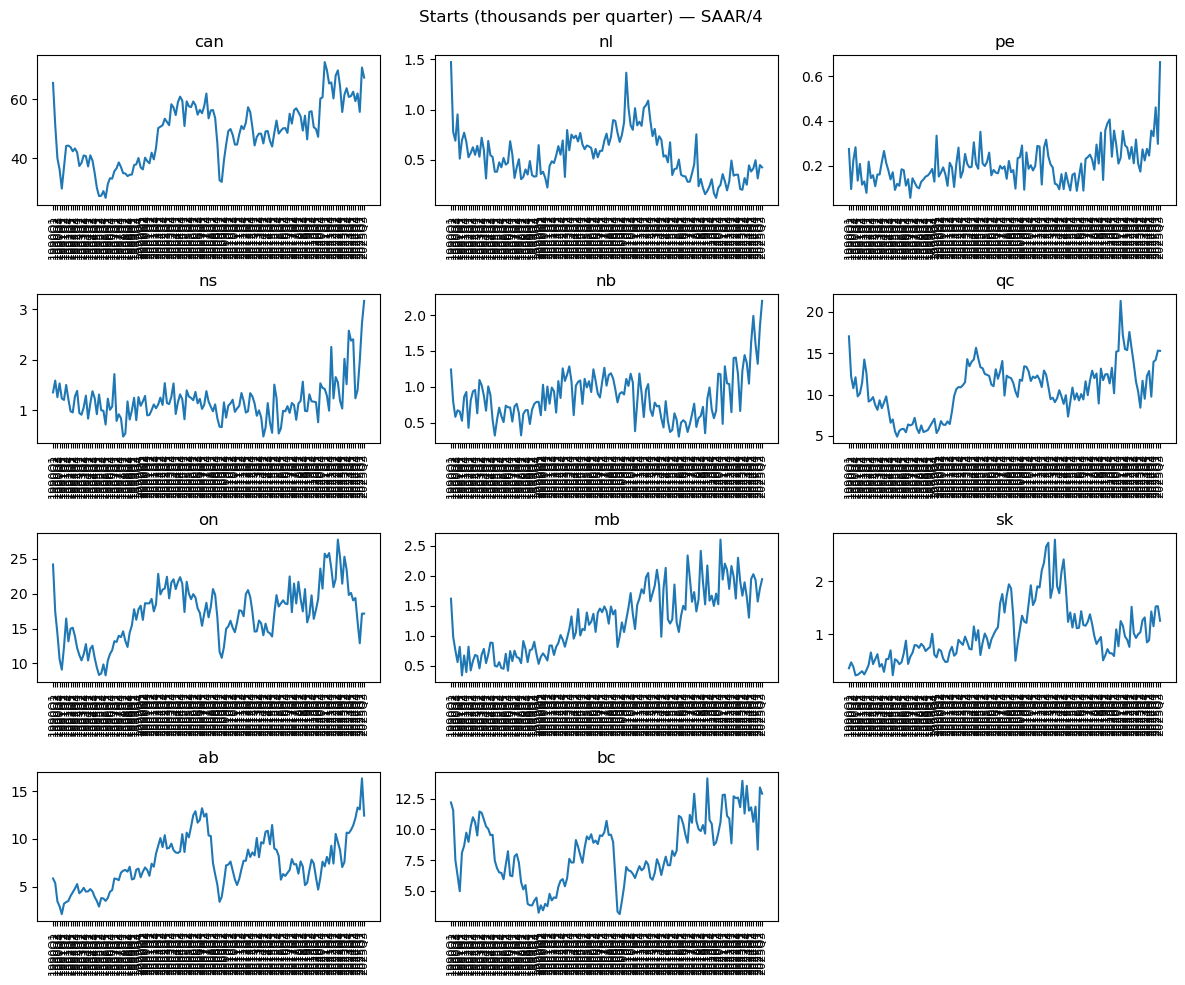

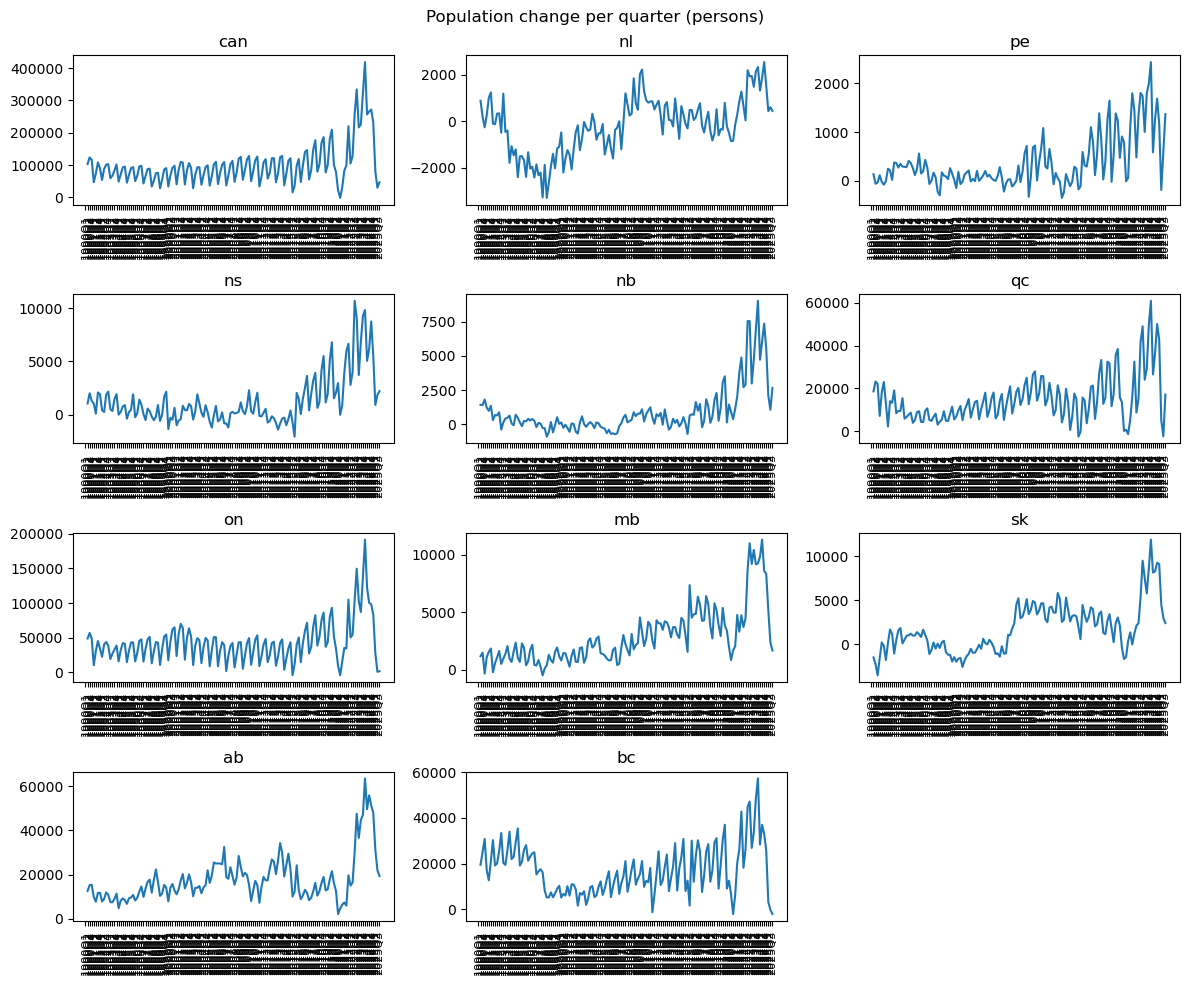

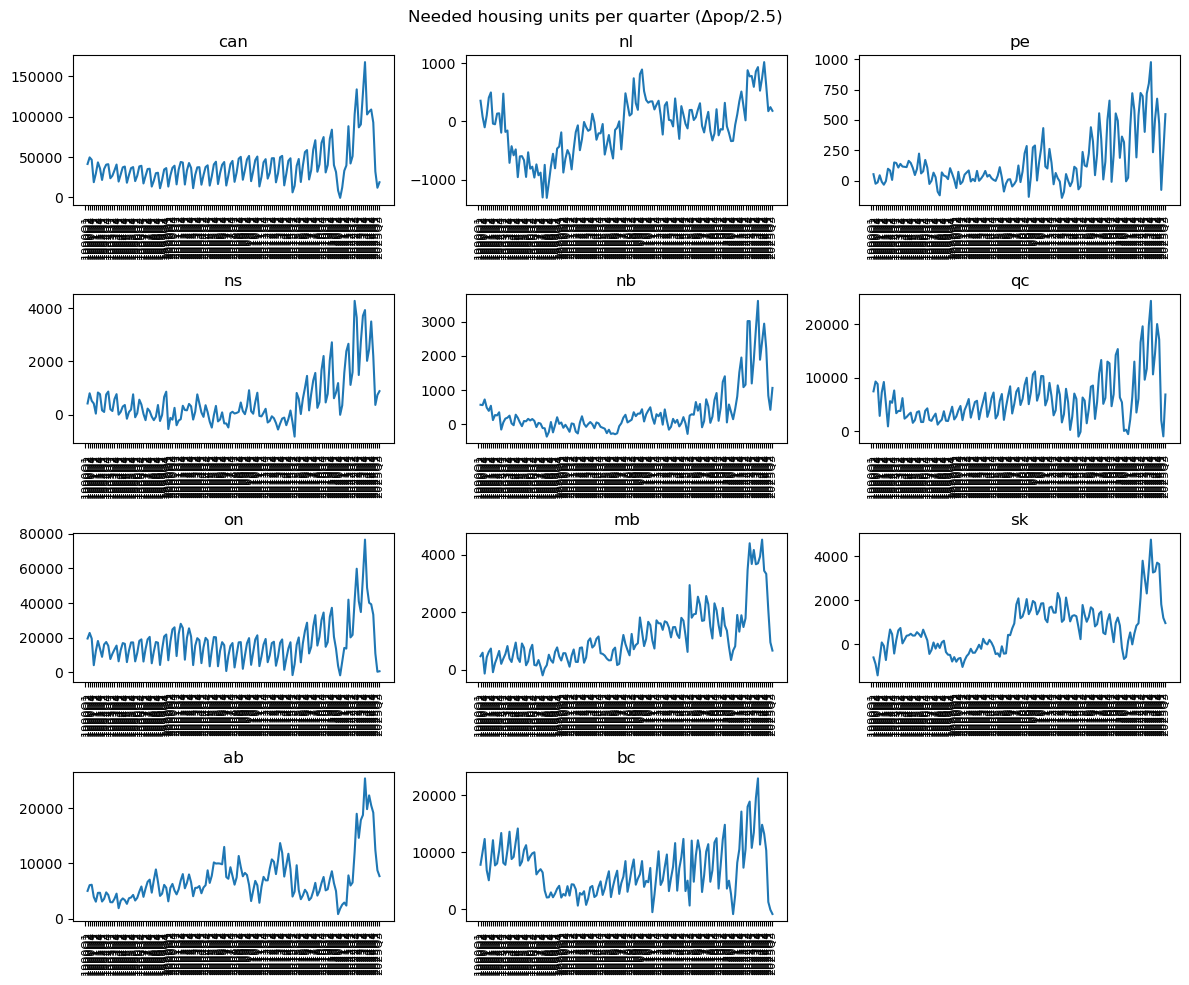

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_71342/3226503737.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=provinces, showmeans=True)


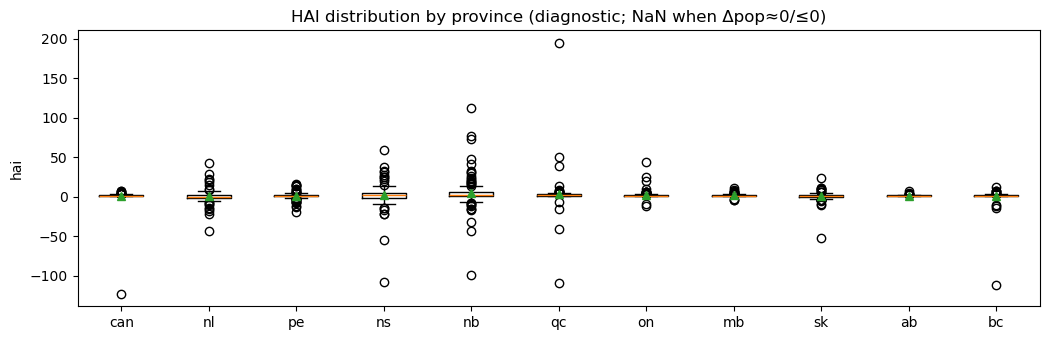

In [12]:

# Time series: starts, pop change, needed units, hai (diagnostic)
plot_time_series(df, "starts_saar_q", "Starts (thousands per quarter) — SAAR/4", ncols=3)
plot_time_series(df, "pop_change_q", "Population change per quarter (persons)", ncols=3)
plot_time_series(df, "needed_units_q", f"Needed housing units per quarter (Δpop/{AHS})", ncols=3)
plot_box_by_province(df, "hai", "HAI distribution by province (diagnostic; NaN when Δpop≈0/≤0)")


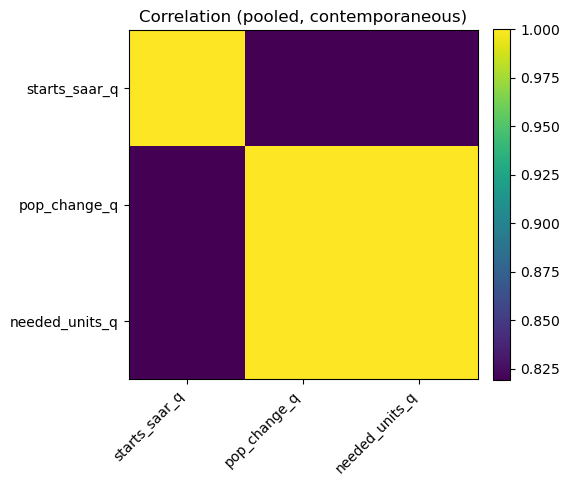

In [13]:

# Correlations (pooled) — choose core variables
corr_cols = ["starts_saar_q","pop_change_q","needed_units_q"]
# add lags once created — but first show contemporaneous
corr_heatmap(df, corr_cols, "Correlation (pooled, contemporaneous)")


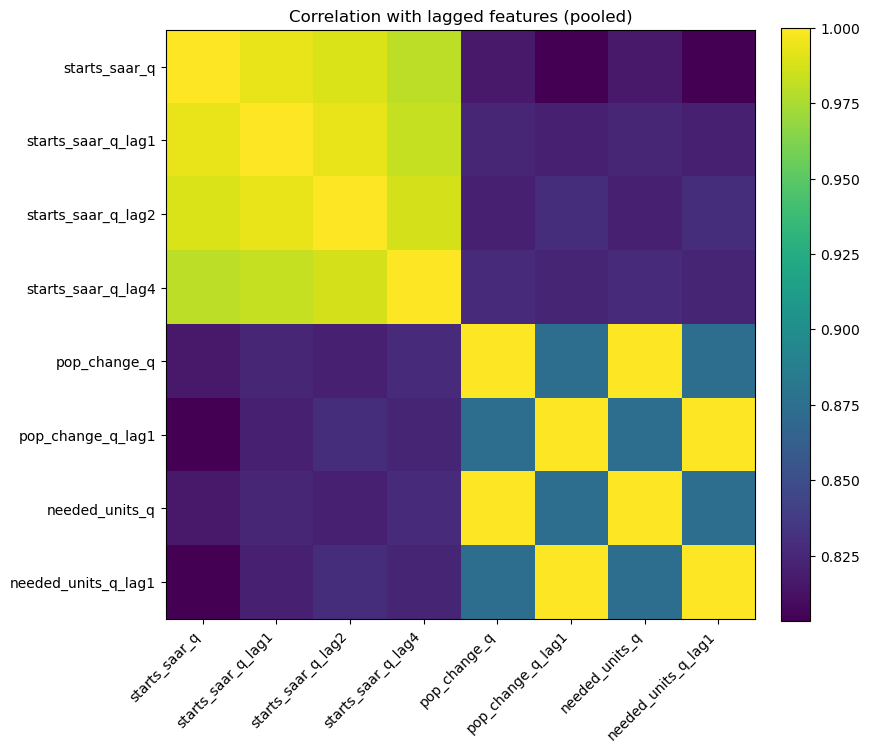

In [14]:

# 3) Feature Engineering: add lags (1,2,4) for key drivers + target
lag_cols = ["starts_saar_q","pop_change_q","needed_units_q"]
df_lag = add_lags(df, lag_cols, lags=[1,2,4])

# After lags, a richer correlation look (pooled)
corr_cols2 = ["starts_saar_q",
                "starts_saar_q_lag1","starts_saar_q_lag2","starts_saar_q_lag4",
                "pop_change_q","pop_change_q_lag1","needed_units_q","needed_units_q_lag1"]
corr_heatmap(df_lag, [c for c in corr_cols2 if c in df_lag.columns], "Correlation with lagged features (pooled)")


In [15]:

# 4) Define modeling frame
feature_cols = [
    "pop_change_q", "needed_units_q",
    "starts_saar_q_lag1", "starts_saar_q_lag2", "starts_saar_q_lag4",
    "pop_change_q_lag1", "needed_units_q_lag1"
]
target_col = "starts_saar_q"

model_df = df_lag.dropna(subset=feature_cols + [target_col]).copy()
print("Modeling rows after lag drop:", model_df.shape[0])


Modeling rows after lag drop: 1529


In [16]:

# 5) Train & Evaluate per province
metrics_df, preds_store = evaluate_models_per_province(
    model_df, split_point=SPLIT_POINT,
    feature_cols=feature_cols, target_col=target_col, seasonality=4
)


In [17]:

# 6) Summaries
print("\n=== Overall metrics (by province & model) ===")
print(metrics_df.head(20))

# Best model per province by RMSE
best_by_rmse = metrics_df.sort_values(["province","RMSE"]).groupby("province").head(1)
print("\n=== Best model per province (by RMSE) ===")
print(best_by_rmse[["province","model","MAE","RMSE","sMAPE(%)","MASE"]])

# Aggregate by model across provinces
agg = metrics_df.groupby("model").agg({"MAE":"mean","RMSE":"mean","sMAPE(%)":"mean","MASE":"mean"}).sort_values("RMSE")
print("\n=== Average metrics across provinces (lower is better) ===")
print(agg)



=== Overall metrics (by province & model) ===
   province           model       MAE       RMSE   sMAPE(%)      MASE
0        ab             gbr  1.502914   1.893972  17.677482  1.038061
1        ab           lasso  1.446598   1.741308  16.541168  0.999164
2        ab              lr  1.448309   1.742853  16.560875  1.000346
3        ab              rf  1.524657   1.914154  17.536317  1.053079
4        ab           ridge  1.444928   1.737710  16.527211  0.998011
5        ab  seasonal_naive  1.880183   2.272287  21.380136  1.298641
6        bc             gbr  1.313453   1.682643  11.798942  0.955762
7        bc           lasso  1.280362   1.727378  11.516719  0.931683
8        bc              lr  1.279585   1.726696  11.509426  0.931117
9        bc              rf  1.411394   1.762433  12.668879  1.027031
10       bc           ridge  1.281717   1.707740  11.518688  0.932669
11       bc  seasonal_naive  1.847366   2.302431  16.484359  1.344275
12      can             gbr  9.422293  10.5

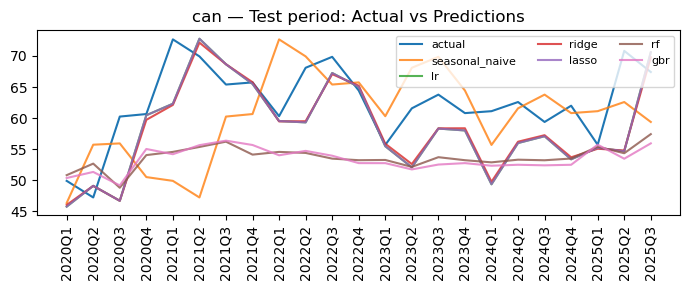

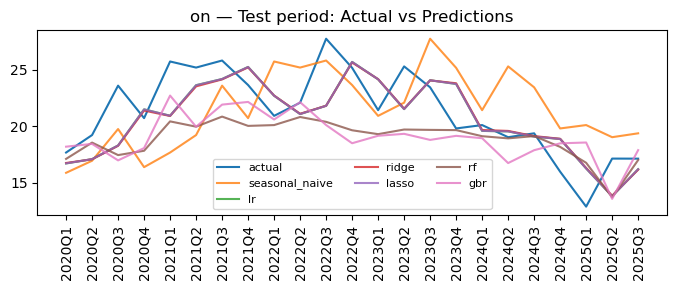

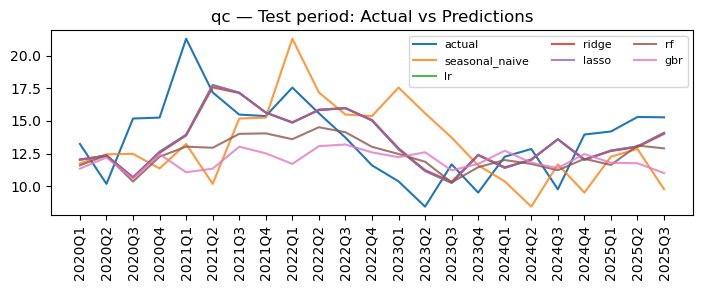

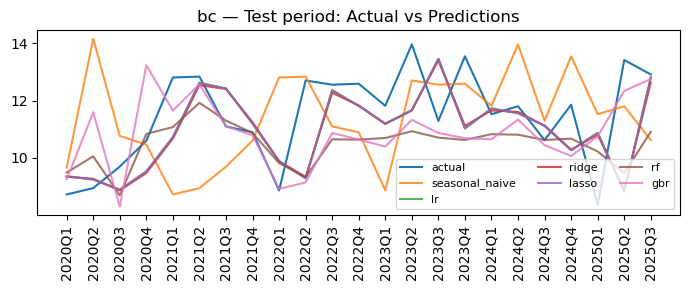

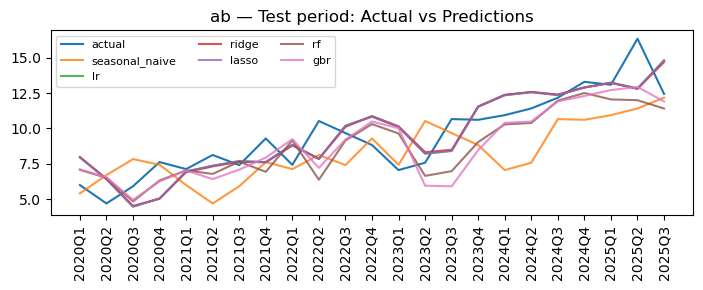

In [18]:

# 7) (Optional) Plot predictions vs actuals for a couple of provinces
for p in [x for x in ["can","on","qc","bc","ab"] if x in preds_store]:
    # find test slice index for any model
    any_model = next(iter(preds_store[p]))
    test_idx = preds_store[p][any_model].index
    sub = model_df.loc[test_idx].copy().sort_values("quarter")
    plt.figure(figsize=(7,3))
    plt.plot(sub["quarter"].astype(str), sub[target_col].values, label="actual")
    for name, pred_ser in preds_store[p].items():
        plt.plot(sub["quarter"].astype(str), pred_ser.values, label=name, alpha=0.8)
    plt.title(f"{p} — Test period: Actual vs Predictions")
    plt.xticks(rotation=90)
    plt.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()


In [ ]:

# 8) (Optional) Future forecast scaffold usage (requires your StatsCan future population projection)

# Example usage (pseudo — you must prepare future_pop_df with columns: quarter, province, population)
# future_pop_df = ...  # your StatsCan projections aligned to quarterly PeriodIndex
# future_pop_df = future_pop_df.sort_values(["province","quarter"]).copy()
# future_pop_df["pop_change_q"] = future_pop_df.groupby("province")["population"].diff()
# future_pop_df["needed_units_q"] = future_pop_df["pop_change_q"] / AHS

# # Attach last known lags from model_df, then call forecast_future
# # First, pick a production model per province (here: use GradientBoosting if available, else RF)
# trained_models = {}
# # Refit on full history per province using chosen model (e.g., 'gbr'):
# reg = build_model_registry()
# for p in model_df["province"].unique():
#     sub = model_df[model_df["province"]==p].dropna(subset=feature_cols + [target_col]).copy()
#     if sub.empty:
#         continue
#     # choose your production model
#     prod_name = "gbr" if "gbr" in reg else "rf"
#     mdl = reg[prod_name]
#     mdl.fit(sub[feature_cols].values, sub[target_col].values)
#     trained_models.setdefault(p, {})[prod_name] = mdl

# future_df = future_pop_df.copy()
# # ensure the feature columns exist (lags for target are filled inside forecast loop)
# for c in feature_cols:
#     if c not in future_df.columns:
#         # we only explicitly need contemporaneous exogenous here; lagged exog are optional
#         if "_lag" in c:
#             future_df[c] = np.nan
#         else:
#             raise ValueError(f"Future DF missing required feature: {c}")

# preds_future = forecast_future(
#     trained_models=trained_models,
#     df_full=model_df,
#     future_df=future_df,
#     feature_cols=feature_cols,
#     target_col=target_col,
#     province_col="province",
#     seasonality=4
# )
# # Adequacy forecast (if you want it on same unit logic):
# # starts_saar_q is in thousands of dwellings/quarter (since SAAR/4).
# # If you want dwellings/quarter as a count, multiply by 1000.
# preds_future["pred_dwelling_starts"] = preds_future["pred_"+target_col] * 1000.0
# preds_future["hai_pred"] = preds_future["pred_dwelling_starts"] / preds_future["needed_units_q"]
# print(preds_future.head())



AttributeError: 'ellipsis' object has no attribute 'sort_values'